### 🔰PyTorchでニューラルネットワーク基礎 #23 【注意行列・attention weightsの可視化】

**内容**
* Qiitaの記事と連動しています
* Transformerを利用したテキスト分類に登場する attention weightsの可視化
* 利用するデータ：data/data_90.zip
* 利用するモデル：model/data_90_bert_type.model
* data_90.zipは解凍して利用
* data_90_bert_type.model: sample_22.ipynbで学習したモデルを保存したものであればOK
* ディレクトリは環境に応じて適宜修正してください

**データについて**
* webサイトへの「ログイン、登録、解約」の３種類の問い合わせを分類する90個データ
* 事前にmecabなどで形態素解析をして単語にIDを割り振り、等長の長さに変換してある
* 文章の形で長さが11になるまでを挿入
* カテゴリー数：３
* 単語数：146
* 系列長（文章の長さ）：11


In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# 可視化のときのライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib
import pickle

In [2]:
def pickle_load(path):
    with open(path, mode="rb") as file:
        data = pickle.load(file)
        return data

# 精度を計算する関数
def accuracy(y, t):
    _, argmax_list = torch.max(y, dim=1)
    accuracy = (argmax_list == t).sum().item()/len(t)
    return accuracy

In [3]:
#デバイスの選択
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("利用デバイス:", device)

利用デバイス: cuda


In [ ]:
# データの読み込み
x = np.loadtxt("data_90/x_train_id_vector.txt", delimiter=",") # .astype(np.int32)
t = np.loadtxt("data_90/y_label.txt", delimiter=",")
x = torch.LongTensor(x)
t = torch.LongTensor(t)

x, x_test, t, t_test = train_test_split(x,t, stratify=t,  random_state=55)

x = x.to(device)
t = t.to(device)
x_test = x_test.to(device)
t_test = t_test.to(device)

# 初期設定
WORDS = 146 # 単語数
SEQ_LEN = 11    # x.shape[1]  # 入力するIDベクトルの長さ
D_MODEL = 16
CLASSES = 3 # sum(1 for line in open("data/y_id2tag.txt"))   # 分類数

### TransformerEncoderLayer・TransformerEncoderの変更

pytorchのバージョンによっては

~~~python
src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
~~~
self.activationでエラーになることもある。その場合は他の活性化関数を試す。self.relu？

In [5]:
class CustomEncoderLayer(nn.TransformerEncoderLayer):
    """注意行列を返すように変更したTransformerEncoderLayer"""
    
    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # 1. MultiheadAttention (Self-Attention)
        src2, attn_weights = self.self_attn(
            src, 
            src, 
            src, 
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,           # 多分ここが重要っぽい
            average_attn_weights=False   # 平均値ではなく、すべてのヘッドの重みを取得したい
        )
        
        # Add & Norm
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        
        # 2. Feed Forward
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        
        # Add & Norm
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        
        # 注意行列を一緒に返すように調整
        return src, attn_weights


class CustomTransformerEncoder(nn.TransformerEncoder):
    """CustomEncoderLayerを受け取り、注意行列も返すように変更したEncoder"""
    
    def forward(self, src, mask=None, src_key_padding_mask=None):
        output = src
        all_attn_weights = []     # この部分を追加　注意行列のリスト
        
        for mod in self.layers:
            output, attn_weights = mod(
                output, 
                src_mask=mask, 
                src_key_padding_mask=src_key_padding_mask
            )
            all_attn_weights.append(attn_weights)

        # normレイヤーがある場合は適用
        if self.norm is not None:
            output = self.norm(output)

        # 最終層の出力と、全レイヤーの注意行列のリストを返す
        return output, all_attn_weights

# DNNの基本構造は第22回と同一
# return y, all_attn_weights に変更

class DNN(nn.Module):
    def __init__(
        self,
        pad_token_id: int=3,  # ここで指定
    ):
        super().__init__()
        self.pad_token_id = pad_token_id
       
        # トークン埋め込み
        self.token_embedding = nn.Embedding(num_embeddings=WORDS, embedding_dim=D_MODEL,padding_idx=self.pad_token_id)
        
        # 学習可能な位置埋め込み（0〜max_len-1）
        self.pos_embedding = nn.Embedding(num_embeddings=SEQ_LEN, embedding_dim=D_MODEL)
        
        # Layer Normalization と Dropout
        #self.layer_norm = nn.LayerNorm(D_MODEL)
        #self.dropout = nn.Dropout(0.1)
        
        # Transformer Encoder
        encoder_layer = CustomEncoderLayer(
            d_model=D_MODEL,
            nhead=4,
            dim_feedforward=32,
            dropout=0.1,
            batch_first=True,   # [batch, seq, d_model] で扱えるように
        )
        self.transformer_encoder = CustomTransformerEncoder(encoder_layer,num_layers=6)
        
        # 文ベクトル → クラス数
        self.classifier = nn.Linear(in_features=D_MODEL, out_features=3)
    
    def forward(self, x):
        # ---- マスクの変換 TransformerEncoder 用: PAD ID=3でPAD のところが True になる mask
        attention_mask = (x != self.pad_token_id).long()
        src_key_padding_mask = (attention_mask == 0)  # [batch, seq_len], bool
        
        # ---- 埋め込み ----
        # トークン埋め込み
        tok_emb = self.token_embedding(x)  # [batch, seq_len, d_model]
              
        # 位置埋め込み
        pos_emb = self.pos_embedding(torch.arange(SEQ_LEN, device=x.device))

        # トークン埋め込み + 位置埋め込み
        x = tok_emb + pos_emb.unsqueeze(0)  # 明示的に次元追加 [batch, seq_len=11, d_model=16]
        
        # Layer Normalization と Dropout
        #x = self.layer_norm(x)
        #x = self.dropout(x)
        
        h, all_attn_weights = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        # <bos>トークン（先頭）に情報を集約
        pooled = h[:, 0, :]  # [batch, d_model]
        
        y = self.classifier(pooled)  # [batch, num_labels=3]    
        #return y
        return y, all_attn_weights


In [6]:
model = DNN()
model.to(device)

DNN(
  (token_embedding): Embedding(146, 16, padding_idx=3)
  (pos_embedding): Embedding(11, 16)
  (transformer_encoder): CustomTransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x CustomEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=32, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=16, out_features=3, bias=True)
)

### 学習する場合

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

LOOP = 50
for epoch in range(LOOP):
    optimizer.zero_grad()
    y,_ = model(x)
    loss = criterion(y, t)
    acc  = accuracy(y,t)
    loss.backward()
    optimizer.step()

    if (epoch+1)%10==0:  
        print(f"{epoch}:\tloss:{loss.item():.3f}\tacc:{acc:.3f}")


9:	loss:0.684	acc:0.612
19:	loss:0.582	acc:0.657
29:	loss:0.455	acc:0.716
39:	loss:0.307	acc:0.881
49:	loss:0.239	acc:0.910


### 学習済みモデルを利用する場合
* 前回学習したモデルを利用してみる。
* transformer_encoder_type.model
* All keys matched successfullyが表示されない場合は、モデルを利用せず学習し直したほうが簡単

In [7]:
model_file = "model/data_90_bert_type.model"
model.load_state_dict(torch.load(model_file, weights_only=True))

<All keys matched successfully>

In [8]:
model.eval()
y_test,_ = model(x_test)
acc = accuracy(y_test, t_test)
print(f"検証精度: {acc}")

検証精度: 0.9130434782608695


# 注意行列・Attention Weightsの可視化

* id2word: IDから単語への辞書
* x[1]: 「入会の方法を教えて」のサンプル文章
* x[1]: はtorch.tensorなので、numpy.ndarrayに戻す

In [ ]:
# IDを単語の戻す辞書の準備
id2word = pickle_load("data_90/id2word_dic.pickle")
id2word[1]

'<bos>'

In [10]:
# サンプル文章
X = x[1]
id_list = X.cpu().detach().numpy()

word_list = []  # あとでヒートマップのラベルとして利用
for id in id_list:
    word_list.append(id2word[id])
word_list

['<bos>', '入会', 'の', '方法', 'を', '教え', 'て', '<eos>', '<pad>', '<pad>', '<pad>']

### 可視化

In [11]:
def visualize_attention(attention_weights, labels, title_info=""):
    """
    注意行列を可視化
    attention_weights: np.ndarray、(seq_len, seq_len)の注意行列
    title_info: str、タイトル情報
    """    
    plt.figure(figsize=(5,5))
    plt.imshow(attention_weights, cmap="Greens", aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(labels)), labels, rotation=75, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.title(title_info)
    plt.tight_layout()
    plt.show()


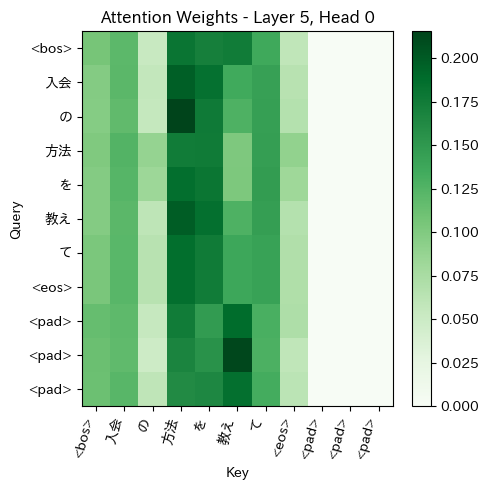

In [12]:
# x[1]：「入会の方法を教えて」の文章
with torch.no_grad():
    output, attentions = model(x[1].unsqueeze(0))

# 5層0ヘッドの重みを抽出
layer_idx = 5    # 5層
head_idx = 0     # 0ヘッド
batch_idx = 0    # 形状を整えるため
attention_weights = attentions[layer_idx][batch_idx, head_idx].cpu().numpy()
labels = word_list    # ['<bos>', '入会', 'の', '方法', 'を', '教え', 'て', '<eos>', '<pad>', '<pad>', '<pad>']
title_info = f"Attention Weights - Layer {layer_idx}, Head {head_idx}"

# ヒートマップ表示
visualize_attention(attention_weights, labels=labels, title_info=title_info)

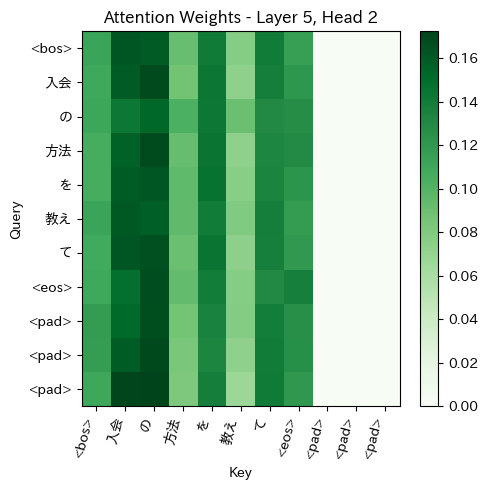

In [13]:
# 5層2ヘッドの重み抽出
layer_idx = 5
head_idx = 2
batch_idx = 0 
attention_weights = attentions[layer_idx][batch_idx, head_idx].cpu().numpy()
labels = word_list
title_info = f"Attention Weights - Layer {layer_idx}, Head {head_idx}"

# ヒートマップ表示
visualize_attention(attention_weights, labels=labels, title_info=title_info)

### 2部グラフを利用した可視化

In [14]:
def visualize_attention_bipartite(attention_weights, tokens, title_info="", threshold=0.15 ,figsize=(3,4)):
    """
    二部グラフ形式で注意重みを可視化
    attention_weights : np.ndarray、(seq_len, seq_len)の注意行列
    tokens : list、単語のリスト（左右の文字を表す） visualize_attentionのlabelsと同じ
    title_info : str、タイトルの情報
    """
    seq_len = len(tokens)
    fig, ax = plt.subplots(figsize=figsize)
    
    # ---- 軸を決める ----
    # (1) 横軸と縦軸の位置を決める(0,0)〜(1,1)の四角のイメージ
    # 横軸の位置を決める。2箇所必要なので０と１で指定
    left_x = 0
    right_x = 1
    
    # 単語の垂直位置（上下反転：1から0へ）
    # 縦軸のメモリを単語数分準備する（0〜1を単語数で分割する）
    # 今回の例だと11個
    y_positions = np.linspace(1, 0, seq_len)

    # ---- 文字表示 ----
    # (2) 2部グラフの起点と終点
    # 左側（起点） Q の単語を順番に表示（右寄せ）
    for i, (token, y) in enumerate(zip(tokens, y_positions)):
        ax.text(left_x - 0.02, y, token, ha="right", va="center", fontsize=10)
    
    # 右側（終点） K の単語を順番に表示（左寄せ）
    for i, (token, y) in enumerate(zip(tokens, y_positions)):
        ax.text(right_x + 0.02, y, token, ha="left", va="center", fontsize=10)
    
    # ---- 線分を描画 ----
    # Qの各単語からKの各単語への接続を描画
    # (3)
    for i in range(seq_len):  # 左側 Q
        weights = attention_weights[i] # Qの単語からKの単語への重み
        
        # weightsを先頭から数値の大きさに従い線を描画
        # (left_x, y_position[i]) ---> (right_x, y_position[j])
        # (4)
        for j in range(seq_len):  # 右側 K
            weight = weights[j]
            if weight > threshold:  # threshold以下は無視
                alpha = min(weight * 2, 1.0)    # 透明度 0〜1の範囲なので適宜調整
                linewidth = weight * 3          # 線の太さ 1.5が標準なので適宜調整
                ax.plot([left_x, right_x], [y_positions[i], y_positions[j]], color="blue", linestyle="-", alpha=alpha, linewidth=linewidth)
    
    # (5) グラフの設定    
    ax.set_xlim(-0.3, 1.3)    # 横軸ちょっと広め
    ax.set_ylim(-0.05, 1.05)  # 縦軸ちょっと広め
    ax.axis("off")
    ax.set_title(title_info)
    plt.tight_layout()
    return fig                # plt.show()やめて戻り値つけてみた。好みに応じて変更してください。

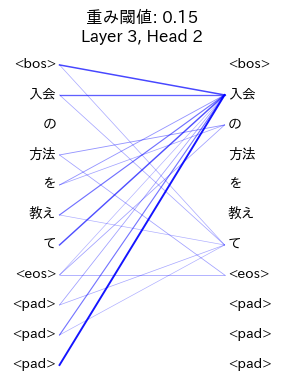

In [15]:
# 条件の設定
# 特定のレイヤーとヘッドの注意行列を指定
layer_idx = 3
head_idx = 2
attention_weights = attentions[layer_idx][0, head_idx].cpu().numpy()  # (seq_len, seq_len) np.ndarray
tokens = word_list  # ['<bos>', '入会', 'の', '方法', 'を', '教え', 'て', '<eos>', '<pad>', '<pad>', '<pad>']  # 単語のリスト
threshold = 0.15    # 閾値
title_info = f"重み閾値: {threshold}\nLayer {layer_idx}, Head {head_idx}"

fig = visualize_attention_bipartite(
    attention_weights, 
    tokens,
    title_info = title_info,
    threshold=threshold
    )
plt.show()